In [13]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score 
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#function for loading the data
def loadData():
    df=pd.read_csv("mnist_train.csv")
    df1=pd.read_csv("mnist_test.csv")
    total=[df,df1]  
    df=pd.concat(total)   #combining the dataset
    #separating x and y
    x=df.iloc[:,1:]
    y=df.iloc[:,0]
    b = np.zeros((y.size, y.max()+1))
    b[np.arange(y.size),y] = 1 #performing one-hot encoding
    y=b
    
    return np.array(x),np.array(y)

In [3]:
def train_val_test_split(x,y):
    trainX=[]
    testX=[]
    trainY=[]
    testY=[]
    valX=[]
    valY=[]
    #we have train:val:test = 7:2:1
    trainFreq=int((7/10)*x.shape[0])
    valFreq=int((2/10)*x.shape[0])
    for i in range(trainFreq):
        trainX.append(x[i])
        trainY.append(y[i])
    for i in range(trainFreq,trainFreq+valFreq):
        valX.append(x[i])
        valY.append(y[i])
    for i in range(trainFreq+valFreq,x.shape[0]):
        testX.append(x[i])
        testY.append(y[i])
    
    return np.array(trainX),np.array(trainY),np.array(valX),np.array(valY),np.array(testX),np.array(testY)

In [11]:
class MyNeuralNetwork:
    
    def __init__(self,nLayers,layerSize,activation,learningRate,weightInit,batchSize,epoch):
        #assigning values to all the parameters
        self.nLayers=nLayers
        self.layerSize=layerSize
        self.activation=activation
        self.learningRate=learningRate
        self.weightInit=weightInit
        self.batchSize=batchSize
        self.epoch=epoch
        
        #generating bias array
        bias=[]
        for i in range(nLayers-1):
            bias.append(np.zeros(layerSize[i+1]))
        
        #generating weight array
        weight=[]
        for i in range(nLayers-1):
            if(weightInit=='zero'):
                weight.append(np.zero((layerSize[i],layerSize[i+1])))
            elif(weightInit=='random'):
                weight.append(np.random.rand(layerSize[i],layerSize[i+1])*0.01)
            else:
                weight.append(np.random.normal(size=(layerSize[i],layerSize[i+1]))*0.01)
                
        self.bias=bias
        self.weight=weight
    
    def ReLU(self,x):
        #returns after performing relu
        return np.where(x >= 0, x, 0)
    
    def sigmoid(self,x):
        #returns after performing sigmoid
        return 1/(1+np.exp(-x))
    
    def linear(self,x):
        #return the input only, as being linear
        return x
    
    def tanh(self,x):
        #return the tanh
        return np.tanh(x)
    
    def softmax(self,x):
        #returns the softmax
        return np.exp(x)/(np.exp(x).sum(axis=1,keepdims=True))
    
    #all the derivative functions for all the activation functions for backward propagation
    def tanhDerivative(self,x):
        return 1-self.tanh(x)**2
    
    def ReLUDerivation(self,x):
        return np.where(x >= 0, 1, 0)
        
    def sigmoidDerivative(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))
    
    def linearDerivative(self,x):
        return np.ones(x.shape)
    
    def softmaxDerivative(self,x):
        return self.softmax(x)*(1-self.softmax(x))
    
    def leakyReLU(self,x):
        return np.where(x >= 0, x, 0.05*x)
    
    def leakyReLUDerivative(self,x):
        return np.where(x >= 0, 1, 0.05)
    
        
    def activate(self,x):
        #chooses the activation function acc to the parameter choosen
        if(self.activation=='relu'):
            return self.ReLU(x),self.ReLUDerivation(x)
        elif(self.activation=='sigmoid'):
            return self.sigmoid(x),self.sigmoidDerivative(x)
        elif(self.activation=='tanh'):
            return self.tanh(x),self.tanhDerivative(x)
        elif(self.activation=='linear'):
            return self.linear(x),self.linearDerivative(x)
        elif(self.activation=='leakyrelu'):
            return self.leakyReLU(x),self.leakyReLUDerivative(x)
        else:
            return self.softmax(x),self.softmaxDerivative(x)
    
    
    def forwardPropagation(self,x):
        #for performing forward propagation by using the concept nextLayerInput=current*weights+bias
        finalOut=x
        allActivations=[]
        allPreActivations=[]
#         print("finalllllllllll",finalOut)
#         print("weightssssssssssssssss",self.weight)
        for i in range(len(self.weight)-1):
#             print("ccccccccccccccccccccccccccccccc",self.weight[i].shape,self.bias[i].shape)
            layerActivation=np.dot(finalOut,self.weight[i])+self.bias[i]
            finalOut=self.activate(layerActivation)[0]
#             print("ssssssssssssssssssssssssssss",finalOut.shape)
            allActivations.append(finalOut)
            allPreActivations.append(layerActivation)
#         print("sssssssssssssss",finalOut)    
        layerActivation=np.dot(finalOut,self.weight[-1])+self.bias[-1]
        finalOut=self.softmax(layerActivation)
        allActivations.append(finalOut)
        allPreActivations.append(layerActivation)
            
        return (allActivations,allPreActivations)
         
    def backwardPropagation(self,y,yPred,allActivations,allPreActivations):
        
        #backward propagation by using pre stored activations of all layers
        delta=yPred-y
        derivatives=[]
        derivatives.append(delta)
#         print("checkkkkkkkkkkk",allPreActivations)
        for i in range(len(self.weight)-2,-1,-1):
            e=np.dot(delta,self.weight[i+1].T)
#             print("cccccccccccccccccccc",e.shape)
#             print('ssssssssssssssssssssssssss',allPreActivations[i].shape)
            delta=e*self.activate(allPreActivations[i])[1]
            
            derivatives.append(delta)
        
        return derivatives[::-1]
    
            
    def fit(self,x,y,xVal,yVal):
        #function to train the model
        #performs forward progation to calculate the output then performs backward propagation in order to update the weights
        #also calculates error and accuracy
        #returns erros and accuracy of inputs
        allTrainError=[]
        allValError=[]
        accuracy=[]
        allValAccuracy=[]
        for i in range(self.epoch):
            for size in range(0,x.shape[0],self.batchSize):
#                 print("size",size)
                xNew=[]
                yNew=[]
                for temp in range(self.batchSize):
#                     print("temp",temp)
                    if(temp+size>=x.shape[0]):
                        break
                    xNew.append(x[size+temp])
                    yNew.append(y[size+temp])
#                 print("xnewwwwwwwwwwwwwwwwwwww",np.array(xNew))
                xNew=np.array(xNew)
                yNew=np.array(yNew)
                allActivations,allPreActivations=self.forwardPropagation(xNew)
                yPred=allActivations[-1]
                
                derivatives=self.backwardPropagation(yNew,yPred,allActivations,allPreActivations)
#                 allActivations[-1]=xNew
                self.updateWeights(xNew,allActivations,derivatives)
            
            yPredVal=self.predict_prob(xVal)
            valError=self.crossEntropyLoss(yPredVal,yVal)
            trainError=self.crossEntropyLoss(yPred,yNew)
            allTrainError.append(trainError)
            allValError.append(valError)
            accuracy.append(self.score(xNew,yNew))
            allValAccuracy.append(self.score(xVal,yVal))
#             if(((i+1)%5)==0):
#                 print("For the epoch ",i+1,"error = ",trainError)
                
        
        return np.array(allTrainError),np.array(accuracy),np.array(allValError),np.array(allValAccuracy)
    
    def updateWeights(self,xNew,allActivations,derivatives):
        #updating the weights and bias by using the derivatives obtained from backward propagation
        for layer in range(len(self.weight)):
            if(layer==0):
                grad=xNew.T.dot(derivatives[layer])/len(xNew)
                self.weight[layer]=self.weight[layer]-self.learningRate*grad
                self.bias[layer]=self.bias[layer]-self.learningRate*np.sum(derivatives[layer],axis=0)/len(xNew)
            else:
                grad=allActivations[layer-1].T.dot(derivatives[layer])/len(xNew)
                self.weight[layer]=self.weight[layer]-self.learningRate*grad
                self.bias[layer]=self.bias[layer]-self.learningRate*np.sum(derivatives[layer],axis=0)/len(xNew)
            
                
        
    def crossEntropyLoss(self,yPred,y):
        #calculates the loss
        logy=-np.log(yPred[np.arange(y.shape[0]),y.argmax(axis=1)])
        return np.sum(logy)/y.shape[0]
    
    def predict_prob(self,x):
        #predicts the class probabilities
        return self.forwardPropagation(x)[0][self.nLayers-2]
    
    def predict(self,x):
        
        return self.predict_prob(x).argmax(axis=1)
    
    def score(self,x,y):
        #return the accuracy
        yPred=self.predict(x)
        y=y.argmax(axis=1)
        acc=accuracy_score(y,yPred)
        return acc
        
                
        
        
        
        
    
        
    

In [5]:
x,y=loadData()
print(x.shape,y.shape)
scaler = StandardScaler()
x=scaler.fit_transform(x)
trainingX,trainingY,validatingX,validatingY,testingX,testingY = train_val_test_split(x,y)
print(validatingX.shape)
print(trainingX.shape)

(70000, 784) (70000, 10)
(14000, 784)
(49000, 784)


In [6]:
classifier=MyNeuralNetwork(6,[784,256, 128, 64,32,10],'relu',0.08,'random',5000,150)
trainErrors,trainAccuracy,valErrors,valAccuracy=classifier.fit(trainingX,trainingY,validatingX,validatingY)


For the epoch  5 error =  2.261500531459628
For the epoch  10 error =  2.186734614778121
For the epoch  15 error =  2.1249239556540997
For the epoch  20 error =  2.0676523660782706
For the epoch  25 error =  2.0178463949088394
For the epoch  30 error =  1.9811220692093265
For the epoch  35 error =  1.939338508417972
For the epoch  40 error =  1.8877773870220467
For the epoch  45 error =  1.8310967587230653
For the epoch  50 error =  1.7809480194853227
For the epoch  55 error =  1.7414343464982935
For the epoch  60 error =  1.7098926936191716
For the epoch  65 error =  1.6835561360467428
For the epoch  70 error =  1.6607262947735704
For the epoch  75 error =  1.64046873842891
For the epoch  80 error =  1.6220168798689742
For the epoch  85 error =  1.6050482506976012
For the epoch  90 error =  1.5892282064232646
For the epoch  95 error =  1.5742134707671207
For the epoch  100 error =  1.5597083037740158
For the epoch  105 error =  1.545437463558969
For the epoch  110 error =  1.531265565

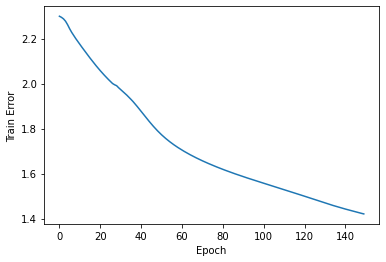

Train Accuracy =  0.41275


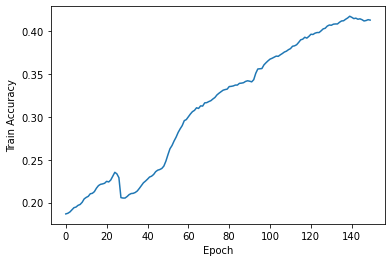

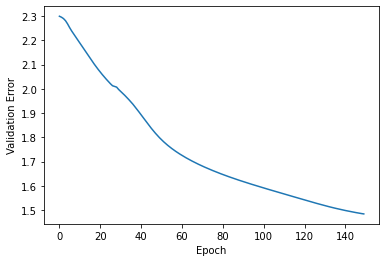

Validation Accuracy =  0.3925


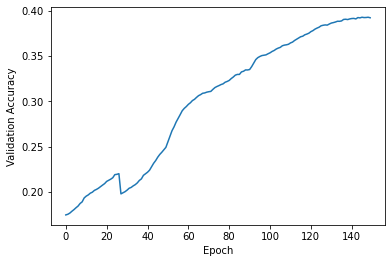

In [7]:
plt.plot(trainErrors)
plt.ylabel("Train Error")
plt.xlabel("Epoch")
plt.show()
print("Train Accuracy = ",trainAccuracy[-1])
plt.plot(trainAccuracy)
plt.ylabel("Train Accuracy")
plt.xlabel("Epoch")
plt.show()
plt.plot(valErrors)
plt.ylabel("Validation Error")
plt.xlabel("Epoch")
plt.show()
print("Validation Accuracy = ",valAccuracy[-1])
plt.plot(valAccuracy)
plt.ylabel("Validation Accuracy")
plt.xlabel("Epoch")
plt.show()

In [9]:
yPredTest=classifier.predict_prob(testingX)
testError=classifier.crossEntropyLoss(yPredTest,testingY)
print("We got a testing final error of ",testError)
testAccuracy=classifier.score(testingX,testingY)
print("We got a testing accuracy of ",testAccuracy)

We got a testing final error of  1.4765223370538998
We got a testing accuracy of  0.4124285714285714


All the graphs for  tanh


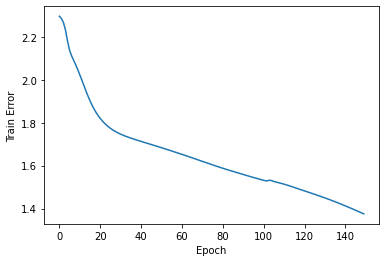

Train Accuracy =  0.4545


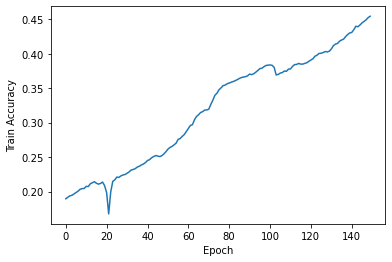

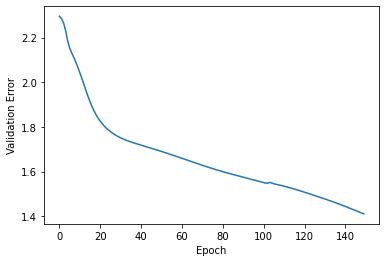

Validation Accuracy =  0.44885714285714284


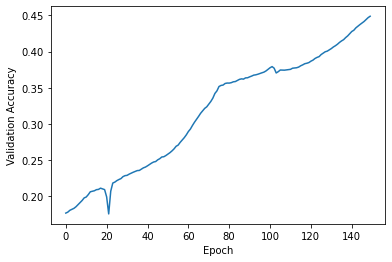

We got a testing final error of  1.3901254169492567
We got a testing accuracy of  0.44557142857142856
------------------------------------------


All the graphs for  sigmoid


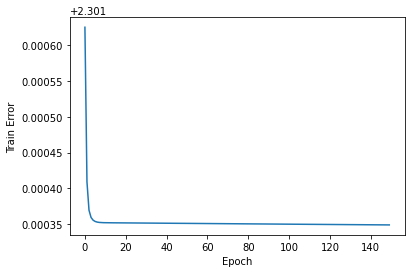

Train Accuracy =  0.1105


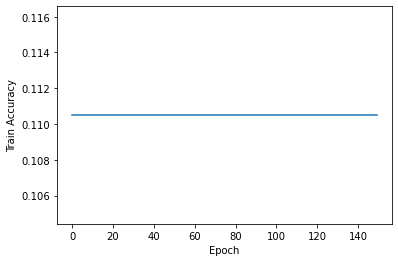

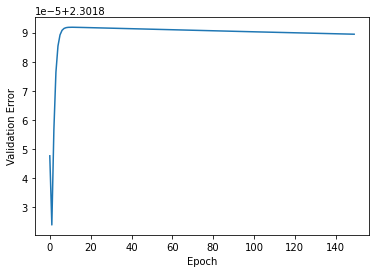

Validation Accuracy =  0.108


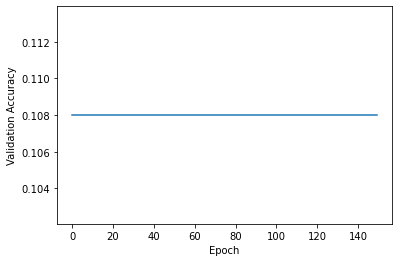

We got a testing final error of  2.3007748385571554
We got a testing accuracy of  0.11357142857142857
------------------------------------------


All the graphs for  linear


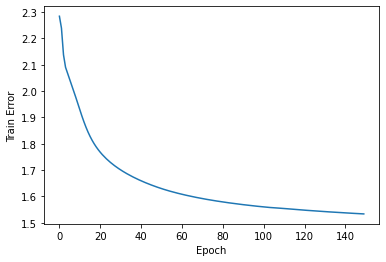

Train Accuracy =  0.381


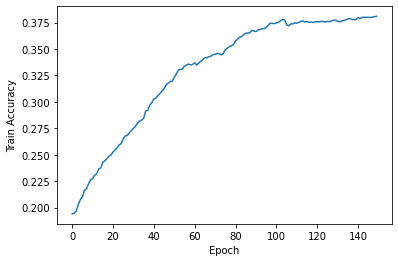

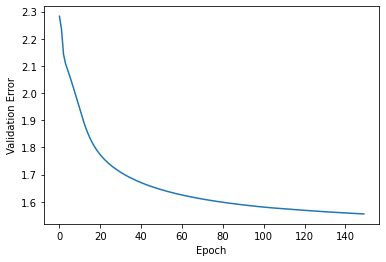

Validation Accuracy =  0.3755


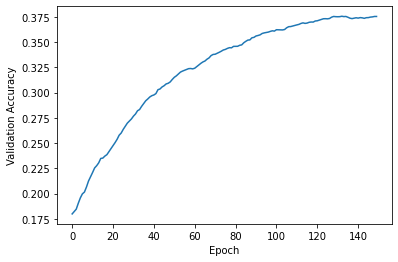

We got a testing final error of  1.527746754365513
We got a testing accuracy of  0.383
------------------------------------------


All the graphs for  leakyrelu


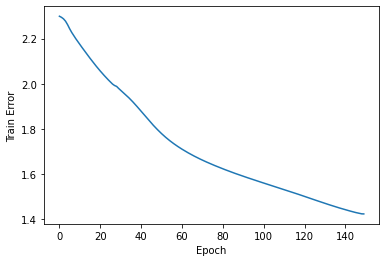

Train Accuracy =  0.412


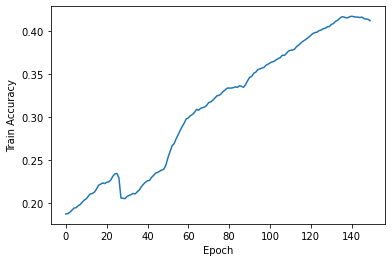

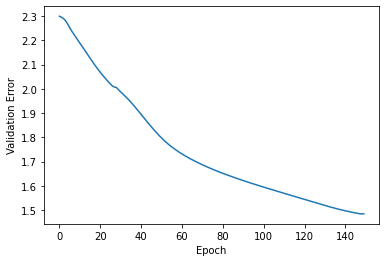

Validation Accuracy =  0.3876428571428571


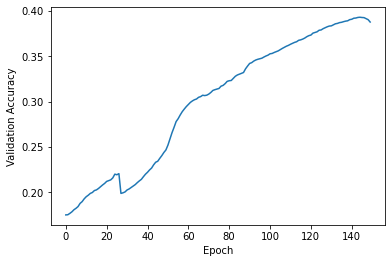

We got a testing final error of  1.4765371603856807
We got a testing accuracy of  0.40885714285714286
------------------------------------------


All the graphs for  softmax


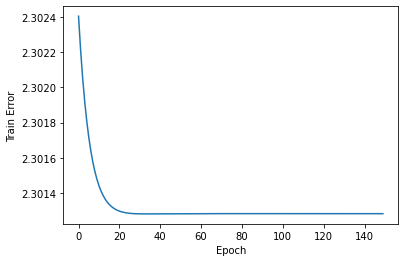

Train Accuracy =  0.1105


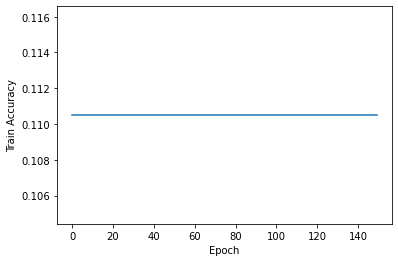

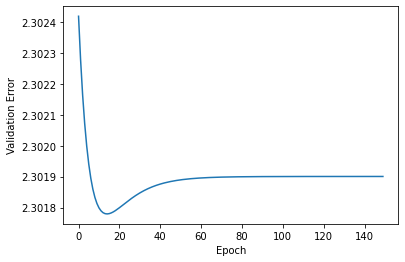

Validation Accuracy =  0.108


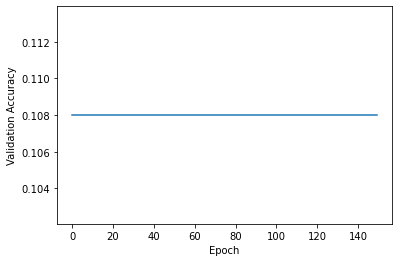

We got a testing final error of  2.3007811214100276
We got a testing accuracy of  0.11357142857142857
------------------------------------------




In [12]:
activationFunctions=['tanh','sigmoid','linear','leakyrelu','softmax']

for func in activationFunctions:
    classifier=MyNeuralNetwork(6,[784,256, 128, 64,32,10],func,0.08,'random',5000,150)
    trainErrors,trainAccuracy,valErrors,valAccuracy=classifier.fit(trainingX,trainingY,validatingX,validatingY)
    
    print("All the graphs for ",func)
    
    plt.plot(trainErrors)
    plt.ylabel("Train Error")
    plt.xlabel("Epoch")
    plt.show()
    print("Train Accuracy = ",trainAccuracy[-1])
    plt.plot(trainAccuracy)
    plt.ylabel("Train Accuracy")
    plt.xlabel("Epoch")
    plt.show()
    plt.plot(valErrors)
    plt.ylabel("Validation Error")
    plt.xlabel("Epoch")
    plt.show()
    print("Validation Accuracy = ",valAccuracy[-1])
    plt.plot(valAccuracy)
    plt.ylabel("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.show()
    
    yPredTest=classifier.predict_prob(testingX)
    testError=classifier.crossEntropyLoss(yPredTest,testingY)
    print("We got a testing final error of ",testError)
    testAccuracy=classifier.score(testingX,testingY)
    print("We got a testing accuracy of ",testAccuracy)
    
    print("------------------------------------------\n\n")

    

In [24]:
#using sklearn to evaluate our implementation.
activationFunctions=['tanh','relu','identity','logistic']
for i in activationFunctions:
    mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32), activation=i,random_state=1, solver='lbfgs', max_iter=150,alpha=0.08,batch_size=5000)
    mlp.fit(trainingX,trainingY)
#     print("validation accuracy using sklean for activation = ",i, mlp.score(validatingX,validatingY))
    print("testing accuracy using sklean for activation = ",i, mlp.score(testingX,testingY))
#     print("training accuracy using sklean for activation = ",i, mlp.score(trainingX,trainingY))
    print("------------------------------------\n")


testing accuracy using sklean for activation =  tanh 0.9627142857142857
------------------------------------

testing accuracy using sklean for activation =  relu 0.9721428571428572
------------------------------------

testing accuracy using sklean for activation =  identity 0.8535714285714285
------------------------------------

testing accuracy using sklean for activation =  logistic 0.0
------------------------------------



In [ ]:
#for bonus
learningRate=[1,0.1,0.01,0.001]
for i in learningRate:
    classifier=MyNeuralNetwork(6,[784,256, 128, 64,32,10],'tanh',i,'random',3000,100)
    trainErrors,trainAccuracy,valErrors,valAccuracy=classifier.fit(trainingX,trainingY,validatingX,validatingY)
    print("For learning rate = ",i)
    plt.plot(trainErrors)
    plt.plot(valErrors)
    plt.legend(["Training error","Validation error"])
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.show()
#     print("Train Accuracy = ",trainAccuracy[-1])
    plt.plot(trainAccuracy)
    plt.plot(valAccuracy)
    plt.legend(["Training Accuracy","Validation Accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.show()
#     plt.plot(valErrors)
#     plt.ylabel("Validation Error")
#     plt.xlabel("Epoch")
#     plt.show()
# #     print("Validation Accuracy = ",valAccuracy[-1])
#     plt.plot(valAccuracy)
#     plt.ylabel("Validation Accuracy")
#     plt.xlabel("Epoch")
#     plt.show()
    yPredTest=classifier.predict_prob(testingX)
    testError=classifier.crossEntropyLoss(yPredTest,testingY)
    print("We got a testing final error of ",testError)
    testAccuracy=classifier.score(testingX,testingY)
    print("We got a testing accuracy of ",testAccuracy)
    print("----------------------------------------------------------\n\n")
    